In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
range_min= 0.45
range_max= 10.0
angle_min= -0.521567881107
angle_max= 0.524276316166
angle_increment= 0.00163668883033

In [4]:
a=!cat ranges.txt

In [5]:
ranges = np.array([float(x) for x in a[0].strip().strip('[]').split(',')])

In [6]:
ranges[:10]

array([3.58638954, 3.58474302, 3.58310175, 3.58146667, 3.5782125 ,
       3.57659388, 3.57498074, 3.57337379, 3.57177234, 3.57017684])

In [7]:
ranges.shape

(640,)

In [198]:
def ranges2cart(ranges, range_min, range_max, angle_min, angle_increment):
    imgsize = 200
    rangestep = 10.0/imgsize
    ranges = np.array(ranges)
    r,phi = np.mgrid[0:range_max:rangestep,-np.pi:np.pi:angle_increment]
    phimin_index = int((angle_min+np.pi)/angle_increment)
    ranges2d = np.zeros(r.shape)
    ranges2d[:,phimin_index:phimin_index+ranges.shape[0]]=ranges
    ranges2d[np.isnan(ranges2d)] = range_max+2
    v = np.zeros(r.shape)
    v[r>ranges2d] = 0
    v[r<ranges2d] = -1
    v[r<range_min] = 0
    v[(ranges2d!=0) & (np.abs(r-ranges2d)<0.1)] =1
    dst = cv2.linearPolar(v.T, (imgsize,imgsize),imgsize,cv2.WARP_FILL_OUTLIERS | cv2.WARP_INVERSE_MAP)
    dst2 = np.zeros((imgsize*2,imgsize*2))
    dst2[:,imgsize:] = dst[:imgsize*2,:][:,::-1] 
    return dst2

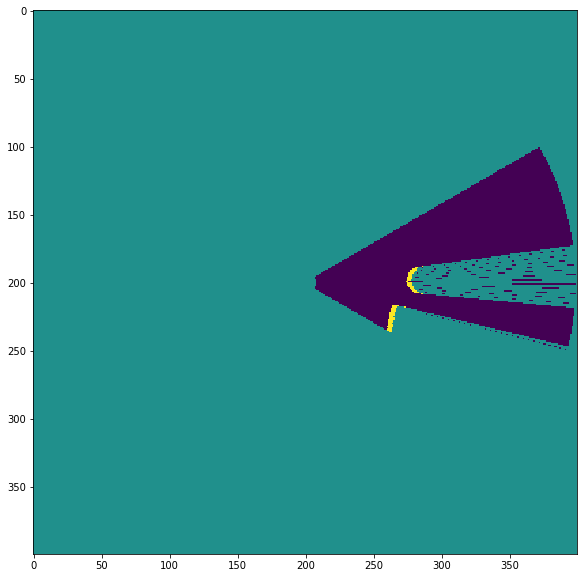

In [199]:
laserscan = ranges2cart(ranges, range_min, range_max, angle_min, angle_increment)
plt.imshow(laserscan)

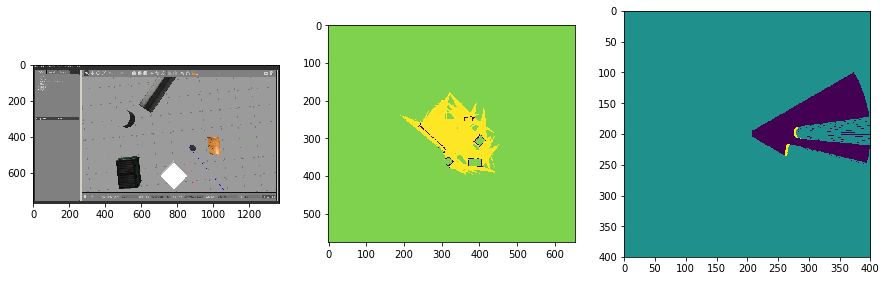

In [240]:
screenshot = cv2.cvtColor(cv2.imread('Screenshot.png'), cv2.COLOR_BGR2RGB)
map2 = cv2.cvtColor(cv2.imread('map2.pgm'), cv2.COLOR_BGR2RGB)[:,:,0]
map2 = cv2.resize(map2,None,fx=1.2, fy=1.2, interpolation = cv2.INTER_NEAREST)
fig, axarr = plt.subplots(1,3)
axarr[0].imshow(screenshot)
axarr[1].imshow(map2)
axarr[2].imshow(laserscan)
fig.set_size_inches((15,5))

In [277]:
map3 = map2.astype(float)

In [278]:
set(map2.flatten())

{0, 205, 254}

In [279]:
map3[map2==0]=1
map3[map2==205]=0
map3[map2==254]=-1
map3.shape, set(map3.flat)

((576, 653), {-1.0, 0.0, 1.0})

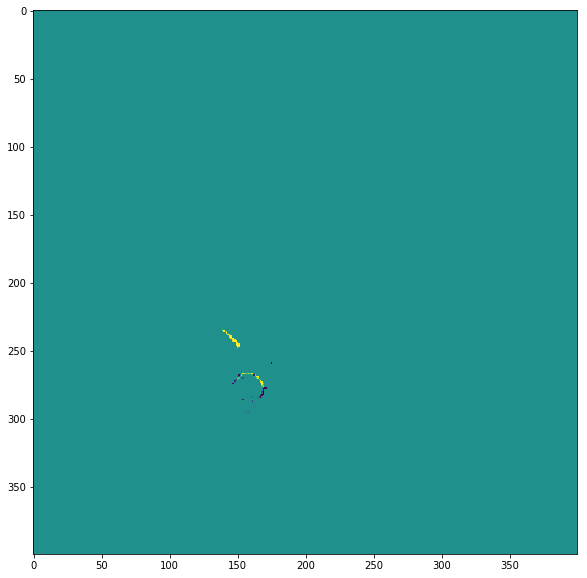

In [341]:
rows,cols = laserscan.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),240,1)
map4 = map3.copy()
map4 = map4[85:,160:][:400,:400]
map4[map4<0]=0 # mapa apenas com obstaculos
map4*=cv2.warpAffine(laserscan,M,(cols,rows))
plt.imshow(map4)

In [453]:
def trypos(worldmap, localmap, x, y, rot):
    rows,cols = localmap.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rot,1)
    map4 = map3.copy()
    map4 = map4[x:,y:][:localmap.shape[0],:localmap.shape[1]]
    map4[map4<0]=0 # mapa apenas com obstaculos
    map4*=cv2.warpAffine(laserscan,M,(cols,rows))
    return sum(map4.flat)

In [ ]:
rng = np.random.RandomState(10)

In [315]:
rng.normal()

-1.5454002921112682

In [323]:
np.random.normal(10)

8.514424982770853

In [ ]:
def showboth(worldscan, laserscan, x,y, rot):
    rows,cols = laserscan.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rot,1)
    map4 = worldscan.copy()
    map4 = map4[x:,y:][:rows,:cols]
    map4[map4<0]=0 # mapa apenas com obstaculos
    map4+=cv2.warpAffine(laserscan,M,(cols,rows))
    plt.imshow(map4)

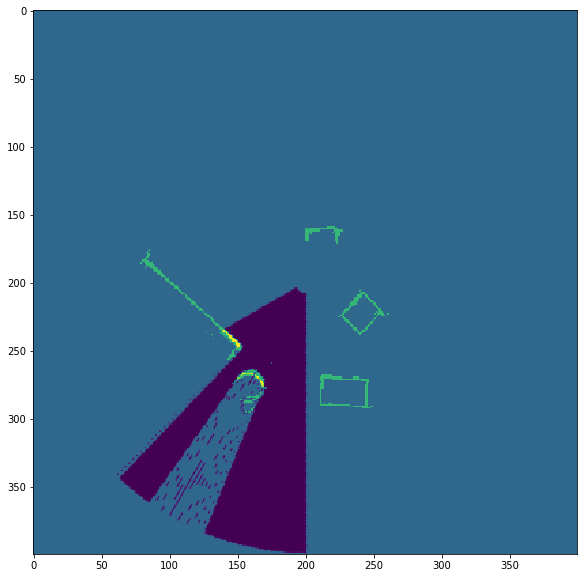

In [393]:
showboth(map3, laserscan, 85,160,240)

In [436]:
best = (85,160,240)
bestresult = trypos(map3, laserscan, *best)

In [545]:
def localrandom(worldmap, laserscan, x, y, rot, smallmax=5, bigmax=15):
    best = (x, y, rot)
    bestresult = trypos(map3, laserscan, *best)
    small = 0
    big = 0
    while(big<bigmax and small<smallmax):
        small += 1
        big += 1
        x = np.random.normal()
        y = np.random.normal()
        alpha = np.random.normal(0.5)
        sample = (int(x+best[0]), int(y+best[1]), alpha + best[2])
        sampleresult = trypos(map3, laserscan, *sample)
        if sampleresult > bestresult:
            small = 0
            best = sample
            bestresult = sampleresult
    return best, bestresult

In [546]:
def localbest(worldmap, laserscan, x, y, rot, maxattempts=200, curresult=None):
    if curresult is None:
        curresult = trypos(map3, laserscan, x, y, rot)
    if maxattempts > 0:
        for multi in [1]:
            for dx,dy,drot in [( 1, 0,0),
                               (-1, 0,0),
                               ( 0, 1,0),
                               ( 0,-1,0),
                               ( 0, 0, angle_increment),
                               ( 0, 0,-angle_increment),
                               ( 0, 0,2* angle_increment),
                               ( 0, 0,2*-angle_increment)
                              ]:
                maxattempts -= 1
                sample = (int(x+multi*dx), int(y+multi*dy), rot+multi*drot)
                sampleresult = trypos(map3, laserscan, *sample)
                if sampleresult > curresult:
                    return localbest(worldmap, laserscan, *sample, maxattempts=maxattempts, curresult=sampleresult)
    return (x,y,rot), curresult

In [547]:
%time best, bestresult=localbest(map3, laserscan, 85, 160, 240)
best, bestresult

CPU times: user 188 ms, sys: 5.18 ms, total: 193 ms
Wall time: 178 ms


((85, 160, 240), 23.8251953125)

In [548]:
%time best, bestresult=localrandom(map3, laserscan, 85, 160, 240)
best, bestresult

CPU times: user 106 ms, sys: 4.16 ms, total: 110 ms
Wall time: 104 ms


((85, 160, 240), 23.8251953125)

In [550]:
for x in range(10):
    print localrandom(map3, laserscan, 85, 160, 240)

((85, 160, 240), 23.8251953125)
((85, 160, 240.44322283650294), 25.701171875)
((85, 160, 240.52582526799017), 25.6015625)
((85, 160, 240), 23.8251953125)
((85, 160, 240), 23.8251953125)
((86, 161, 240.30008872805232), 25.091796875)
((86, 161, 239.5674449679285), 31.4287109375)
((85, 160, 240.6799767449044), 23.9970703125)
((85, 160, 240), 23.8251953125)
((86, 161, 240.38050435732757), 24.021484375)


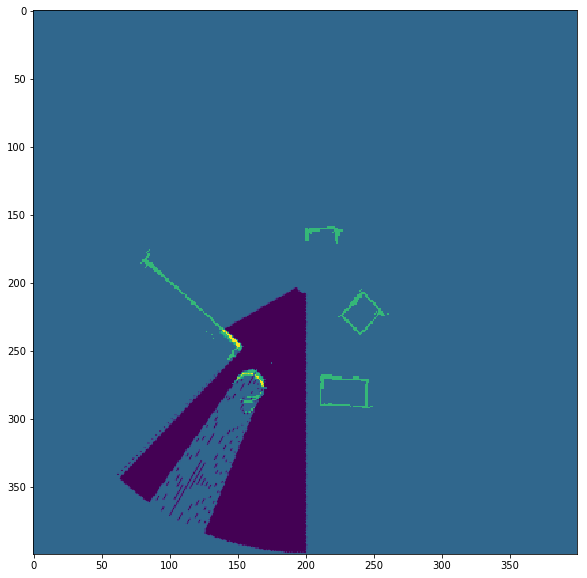

In [502]:
showboth(map3, laserscan, *best)